In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs out of one DataFrame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(168528, 109)


,136474,95910,133737,97844
action_type,TOOL_DISCARDED,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER
elapsed_time,138885,559557,675422,353241
event_time,2023-04-21 10:47:00,2023-06-07 10:53:00,2023-04-21 09:11:00,2023-06-12 14:35:00
session_uuid,313259a4-162f-44f6-8479-92e4554a1464,9fac5a9d-0f55-4473-9744-f7100561354f,3ce991bc-a2d1-46fd-a3a4-d3611e946ed7,a0987257-801e-44c5-a1ad-81e0083bfa46
file_name,max14,9fac5a9d-0f55-4473-9744-f7100561354f,max12,a0987257-801e-44c5-a1ad-81e0083bfa46
logger_version,1.0,1.0,1.0,1.0
time_group,1,2,2,1
tool_hover_type,NaN,Hemostatic Gauze,Hemostatic Gauze,Gauze
tool_hover_count,NaN,999,999,1000
tool_discarded_type,Hemostatic Gauze,NaN,NaN,NaN


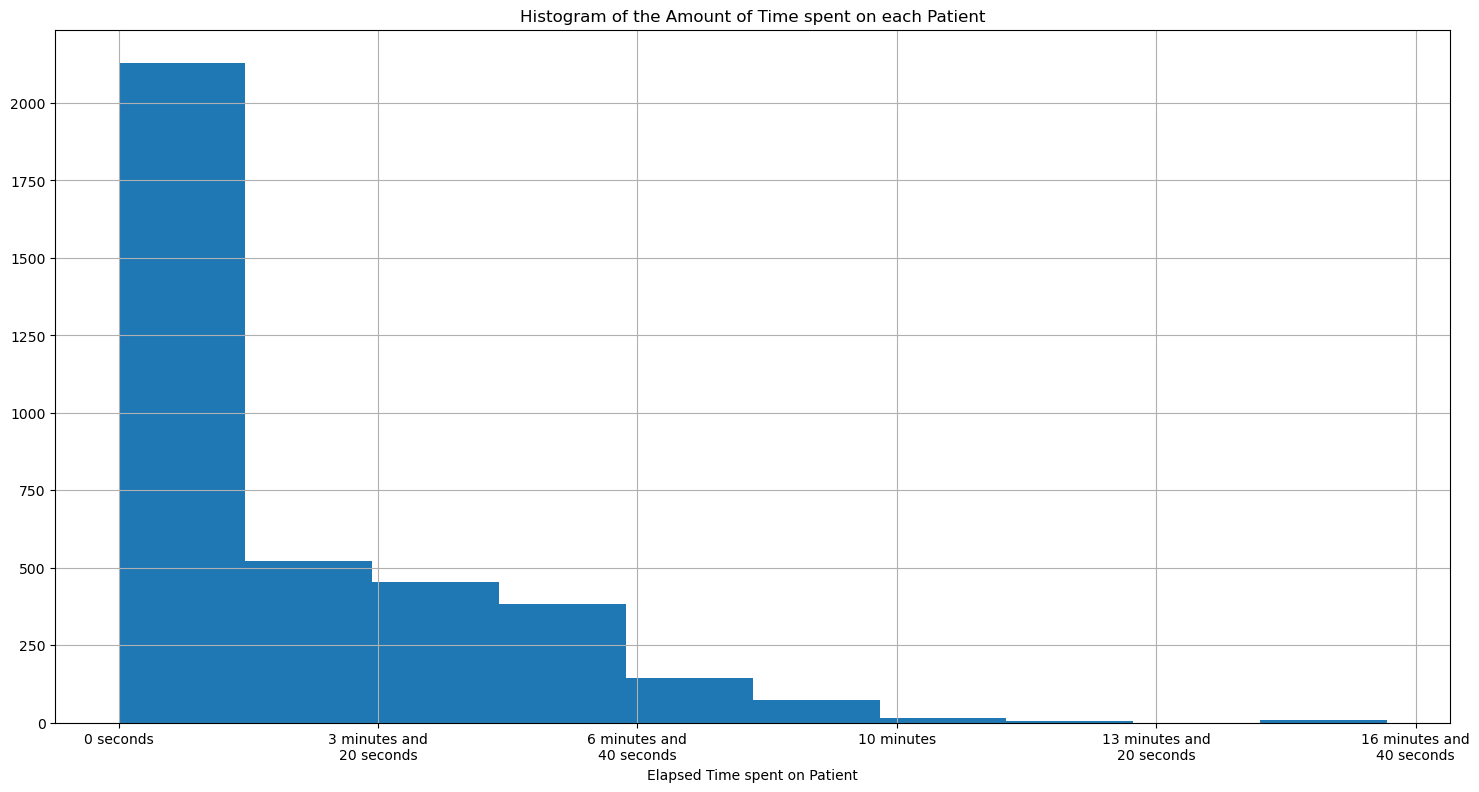

In [4]:

from matplotlib.text import Text
import humanize
from datetime import timedelta

rows_list = []

# Get all SESSION_START and _END periods
for (session_uuid, time_group), df1 in nu.get_session_groupby(
	mask_series=None, extra_column='time_group'
):
	
    # Get all patients in that period
    for patient_id, df2 in df1.groupby('patient_id'):
        row_dict = {}
        row_dict['session_uuid'] = session_uuid
        row_dict['time_group'] = time_group
        row_dict['patient_id'] = patient_id
        
        # Get the timeline for patient engagement
        xmin = df2.elapsed_time.min(); row_dict['engagement_start'] = xmin
        xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
        engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta
        rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
engagement_delta_df.engagement_delta.hist(ax=ax)

# Set the title and labels
ax.set_title(f'Histogram of the Amount of Time spent on each Patient')
ax.set_xlabel('Elapsed Time spent on Patient')

# tick_locations = ax.get_xticks()
# print(tick_locations)

tick_labels = ax.get_xticklabels()
# print(tick_labels)

ax.set_xticklabels([
    Text(-200000.0, 0, ''), Text(0.0, 0, '0 seconds'),
    Text(200000.0, 0, humanize.precisedelta(timedelta(milliseconds=200000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(400000.0, 0, humanize.precisedelta(timedelta(milliseconds=400000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(600000.0, 0, humanize.precisedelta(timedelta(milliseconds=600000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(800000.0, 0, humanize.precisedelta(timedelta(milliseconds=800000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(1000000.0, 0, humanize.precisedelta(timedelta(milliseconds=1000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(1200000.0, 0, '')
]);

In [15]:

# Get all time groups and an action timeline of each patient and compute the engagement delta
actions_list = ['INJURY_RECORD', 'PATIENT_RECORD', 'S_A_L_T_WALK_IF_CAN', 'S_A_L_T_WAVE_IF_CAN', 'S_A_L_T_WAVED']
rows_list = []
for (session_uuid, time_group), df1 in nu.get_session_groupby(
	mask_series=None, extra_column='time_group'
):
	
    # Get all patients in that period
    for patient_id, df2 in df1.groupby('patient_id'):
        row_dict = {}
        row_dict['session_uuid'] = session_uuid
        row_dict['time_group'] = time_group
        row_dict['patient_id'] = patient_id
        
        # Get the timeline for patient engagement
        mask_series = df2.action_type.isin(actions_list)
        xmin = df2[~mask_series].elapsed_time.min(); row_dict['engagement_start'] = xmin
        xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
        engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta

        # Get a sequence of elapsed times for patient engagements
        times_list = [xmin]
        mask_series = df2.action_type.isin(['PATIENT_ENGAGED'])
        times_list += df2[mask_series].sort_values('elapsed_time').elapsed_time.tolist()

        # Ccompute their differences
        deltas_list = []
        for i in range(len(times_list) - 1):
            deltas_list.append(times_list[i + 1] - times_list[i])

        # Add these in separate columns
        for i, delta in enumerate(deltas_list):
            row_dict[f'delta{i:02d}'] = delta
        
        rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)

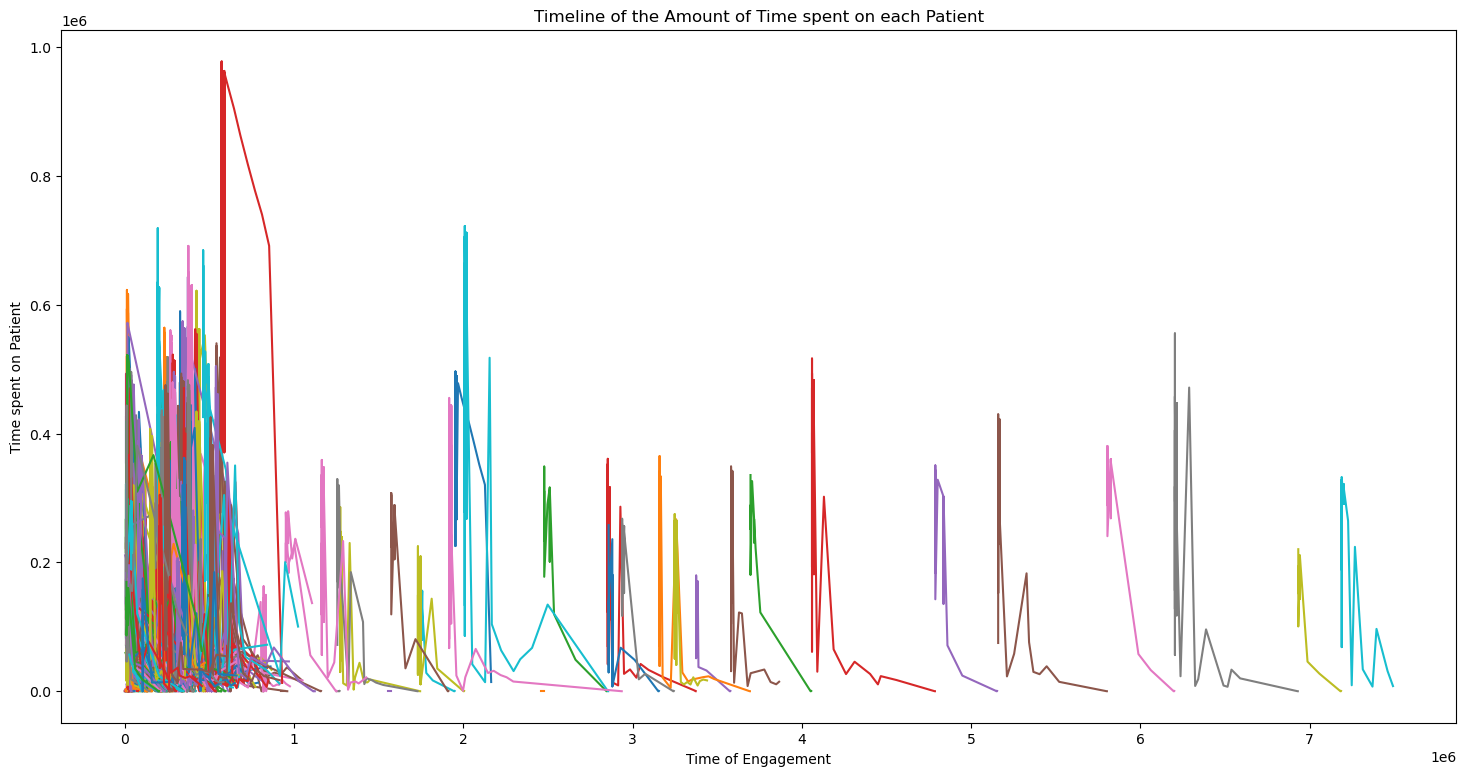

In [34]:

# Add all time groups as line plots of engagement start vs delta
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
for (session_uuid, time_group), df in engagement_delta_df.groupby(['session_uuid', 'time_group']):
    df.sort_values('engagement_start').plot(x='engagement_start', y='engagement_delta', kind='line', ax=ax, label=None)

# Set the title and labels
ax.set_title('Timeline of the Amount of Time spent on each Patient')
ax.set_xlabel('Time of Engagement')
ax.set_ylabel('Time spent on Patient')
legend = plt.legend(loc=None)
legend.set_visible(False);

In [35]:

# Get the time group with the most patients
columns_list = ['session_uuid', 'time_group']
patients_srs = frvrs_logs_df.groupby(columns_list).patient_id.unique().map(lambda x: len(x))
values_tuple = patients_srs.sort_values().tail(1).index.item()
{c: v for c, v in zip(columns_list, values_tuple)}

{'session_uuid': '5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0', 'time_group': 1}

In [36]:

# Get the most patients in one time group
srs = patients_srs.value_counts().sort_index()
mask_series = (srs > 1)
max_ranking = srs[mask_series].tail(1).index.tolist()[0]
print(f'{max_ranking} patients are being seen in one session')

26 patients are being seen in one session


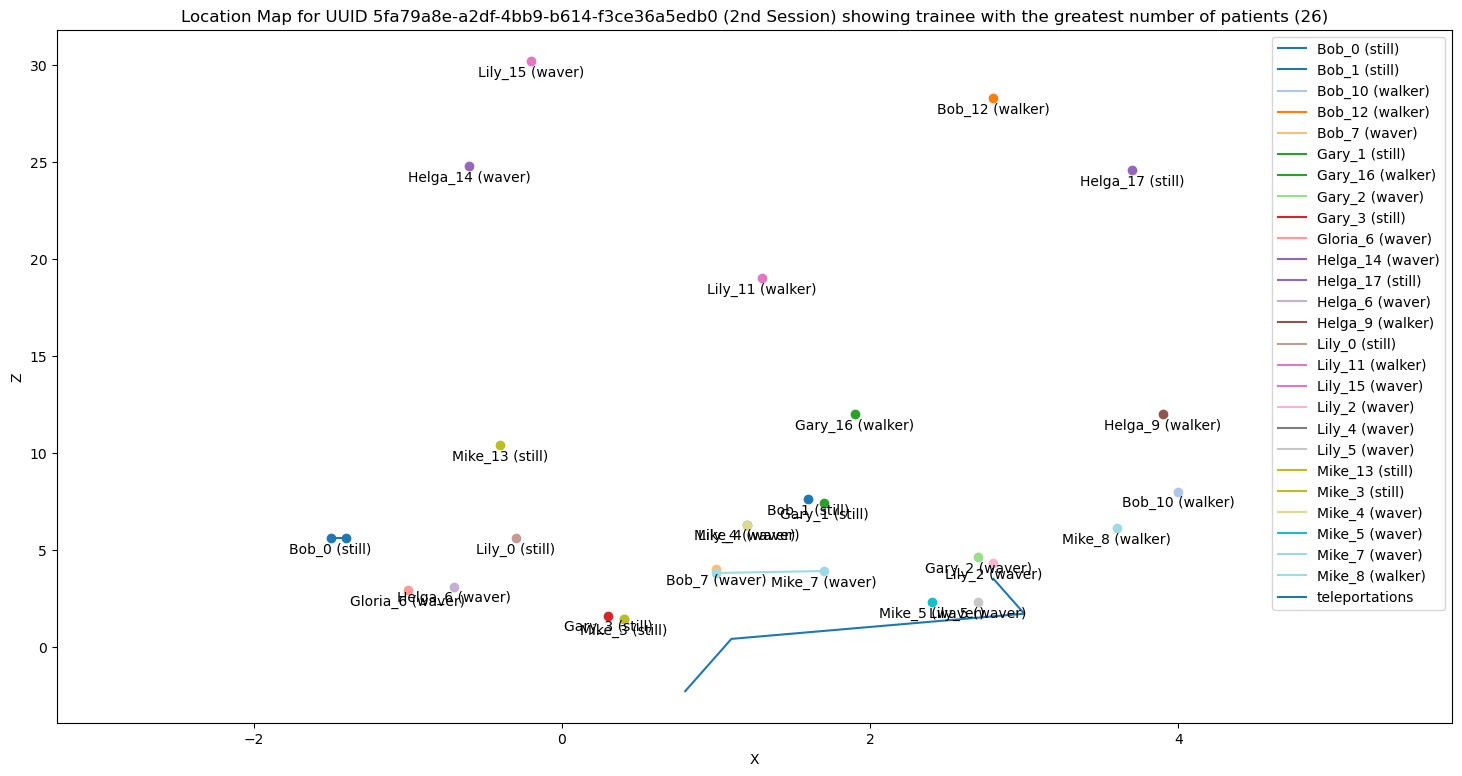

In [37]:

# Visualize the patients in a map
session_uuid = values_tuple[0]
time_group = values_tuple[1]
base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.time_group == time_group)

title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(time_group+1)} Session)'
title += ' showing trainee with the greatest number of patients ('
title += humanize.intword(max_ranking) + ')'
nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

In [43]:

import pandas as pd

# Group the engagement delta patients by session and rank order them
columns_list = ['patient_ranking', 'engagement_start', 'engagement_delta']
patient_ranking_df = DataFrame([], columns=columns_list)
for (session_uuid, time_group), df in engagement_delta_df.groupby(['session_uuid', 'time_group']):
    offset = df.engagement_start.min()
    df.engagement_start = df.engagement_start - offset
    # df.engagement_stop = df.engagement_stop - offset
    columns_list = ['index', 'engagement_start', 'engagement_delta']
    df = df.drop_duplicates(
        subset=['engagement_start', 'engagement_delta']
    ).sort_values('engagement_start').reset_index(drop=True).reset_index(drop=False)[columns_list].rename(
        columns={'index': 'patient_ranking'}
    )#.iloc[:max_ranking]
    # group_max_ranking = df.patient_ranking.max()
    # if group_max_ranking > (max_ranking + 1): raise
    patient_ranking_df = pd.concat([patient_ranking_df, df], axis='index')

In [41]:

patient_ranking_df

,patient_ranking,engagement_start,engagement_delta
0,0,0.0,0.0
1,1,652.0,0.0
2,2,1314.0,0.0
0,0,0.0,153425.0
1,1,1.0,125195.0
...,...,...,...
20,20,105432.0,36517.0
21,21,117511.0,24438.0
22,22,149790.0,20559.0
23,23,176896.0,23394.0


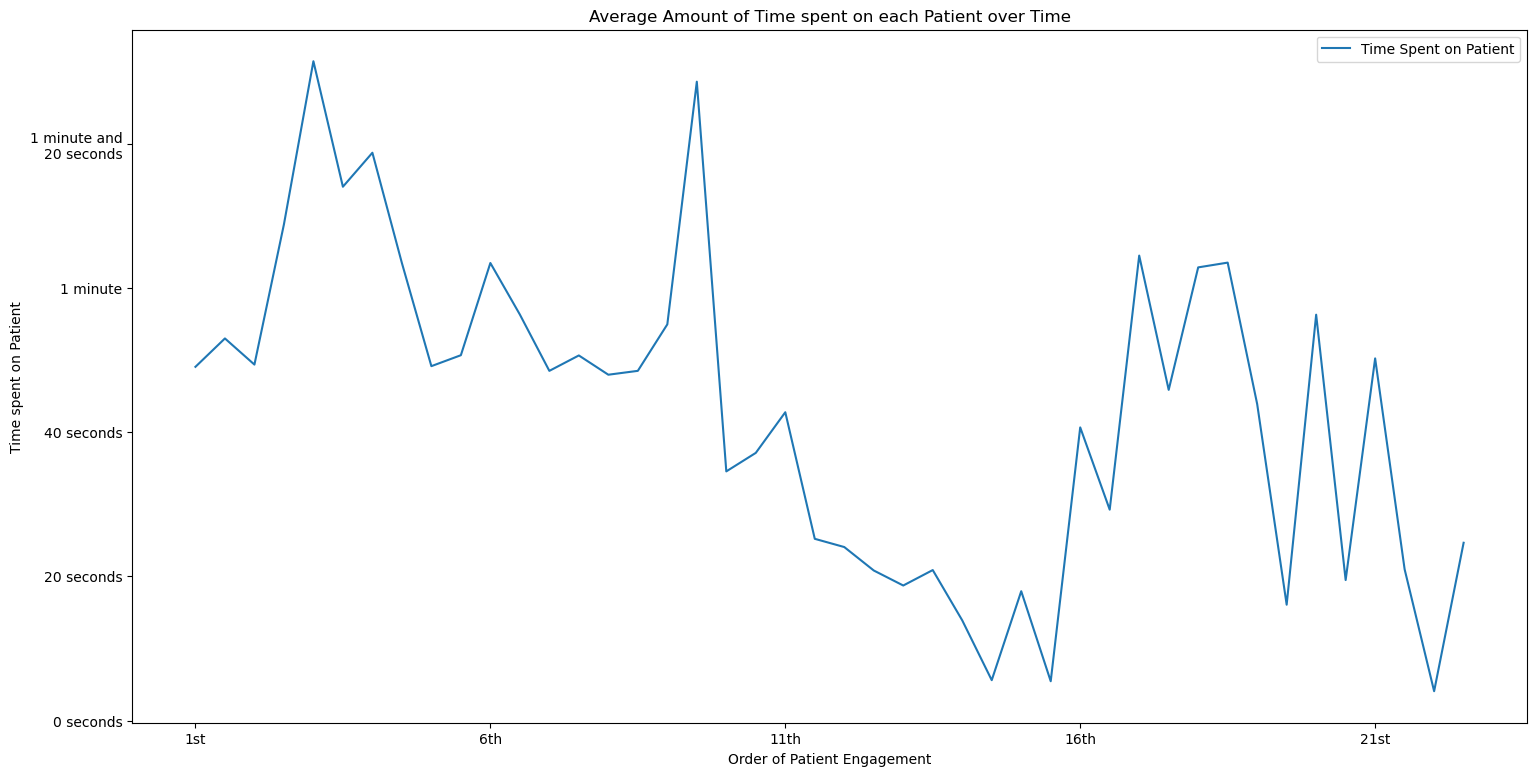

In [42]:

ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
patient_ranking_df.dropna(axis='index', how='any').groupby('patient_ranking').mean().reset_index(drop=False).plot(
    x='patient_ranking', y='engagement_delta', kind='line', label='Time Spent on Patient', ax=ax
)
ax.set_title('Average Amount of Time spent on each Patient over Time')
ax.set_xlabel('Order of Patient Engagement')
ax.set_ylabel('Time spent on Patient')
ax.set_yticklabels([
    Text(-20_000.0, 0, ''), Text(0.0, 0, '0 seconds'),
    Text(20_000.0, 0, humanize.precisedelta(timedelta(milliseconds=20_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(40_000.0, 0, humanize.precisedelta(timedelta(milliseconds=40_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(60_000.0, 0, humanize.precisedelta(timedelta(milliseconds=60_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(80_000.0, 0, humanize.precisedelta(timedelta(milliseconds=80_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(100_000.0, 0, humanize.precisedelta(timedelta(milliseconds=100_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(120_000.0, 0, humanize.precisedelta(timedelta(milliseconds=120_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(140_000.0, 0, humanize.precisedelta(timedelta(milliseconds=140_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(160_000.0, 0, humanize.precisedelta(timedelta(milliseconds=160_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(180_000.0, 0, '')
])
# print(ax.get_xticklabels())
ax.set_xticklabels([
    Text(-5.0, 0, ''),
    Text(0.0, 0, humanize.ordinal(0.0+1)),
    Text(5.0, 0, humanize.ordinal(5.0+1)),
    Text(10.0, 0, humanize.ordinal(10.0+1)),
    Text(15.0, 0, humanize.ordinal(15.0+1)),
    Text(20.0, 0, humanize.ordinal(20.0+1)),
    Text(25.0, 0, humanize.ordinal(25.0+1)),
    Text(30.0, 0, '')
]);

In [16]:

print(engagement_delta_df.columns.tolist())
engagement_delta_df.sample(5).dropna(axis='columns', how='all').T

['session_uuid', 'time_group', 'patient_id', 'engagement_start', 'engagement_stop', 'engagement_delta', 'delta00', 'delta01', 'delta02', 'delta03', 'delta04', 'delta05', 'delta06', 'delta07', 'delta08', 'delta09', 'delta10']


,1182,726,2557,321,2042
session_uuid,5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0,39f689fe-757c-4546-9ded-b695808be738,b52e71ec-050f-49e1-b495-7c36f5537544,158e6365-673b-4030-8b36-6704be5996a2,8ceb28a3-e268-4930-a1c6-84cac4f6239c
time_group,1,1,0,1,1
patient_id,Gary_16 Root,Mike_3 Root,Gary_3 Root,Lily_2 Root,Lily_2 Root
engagement_start,52058.0,140428.0,5972.0,NaN,205780.0
engagement_stop,62018,293787,5972,25715,205780
engagement_delta,9960.0,153359.0,0.0,NaN,0.0
delta00,NaN,0.0,NaN,NaN,NaN


In [47]:

columns_list = [f'delta{i:02d}' for i in range(11)]
df = engagement_delta_df.groupby('patient_id').mean()[columns_list]#.sample(4)
# mask_series = df.index.isin(['Gary_1 Root', 'Gloria_8 Root', 'Helga_10 Root', 'Mike_0 Root', 'Mike_2 Root'])
mask_series = ~df.delta07.isnull()
df = df[mask_series].sort_values('delta00', ascending=False)
display(df)

,delta00,delta01,delta02,delta03,delta04,delta05,delta06,delta07,delta08,delta09,delta10
patient_id,,,,,,,,,,,
Helga_10 Root,318485.839286,89231.500000,20212.000000,16970.666667,3968.5,5467.00,3751.000000,6730.0,NaN,NaN,NaN
Mike_2 Root,147733.881356,66237.181818,28508.647059,16650.300000,2454.0,6333.00,17682.333333,11279.5,4579.0,6600.0,4628.0
Mike_0 Root,135143.923077,110333.100000,30230.111111,18298.300000,16827.5,3253.25,2236.333333,10774.0,17647.0,6552.0,3164.0
Mike_7 Root,375.215517,132313.666667,39755.666667,10176.500000,7165.0,6672.00,7534.000000,22852.0,NaN,NaN,NaN


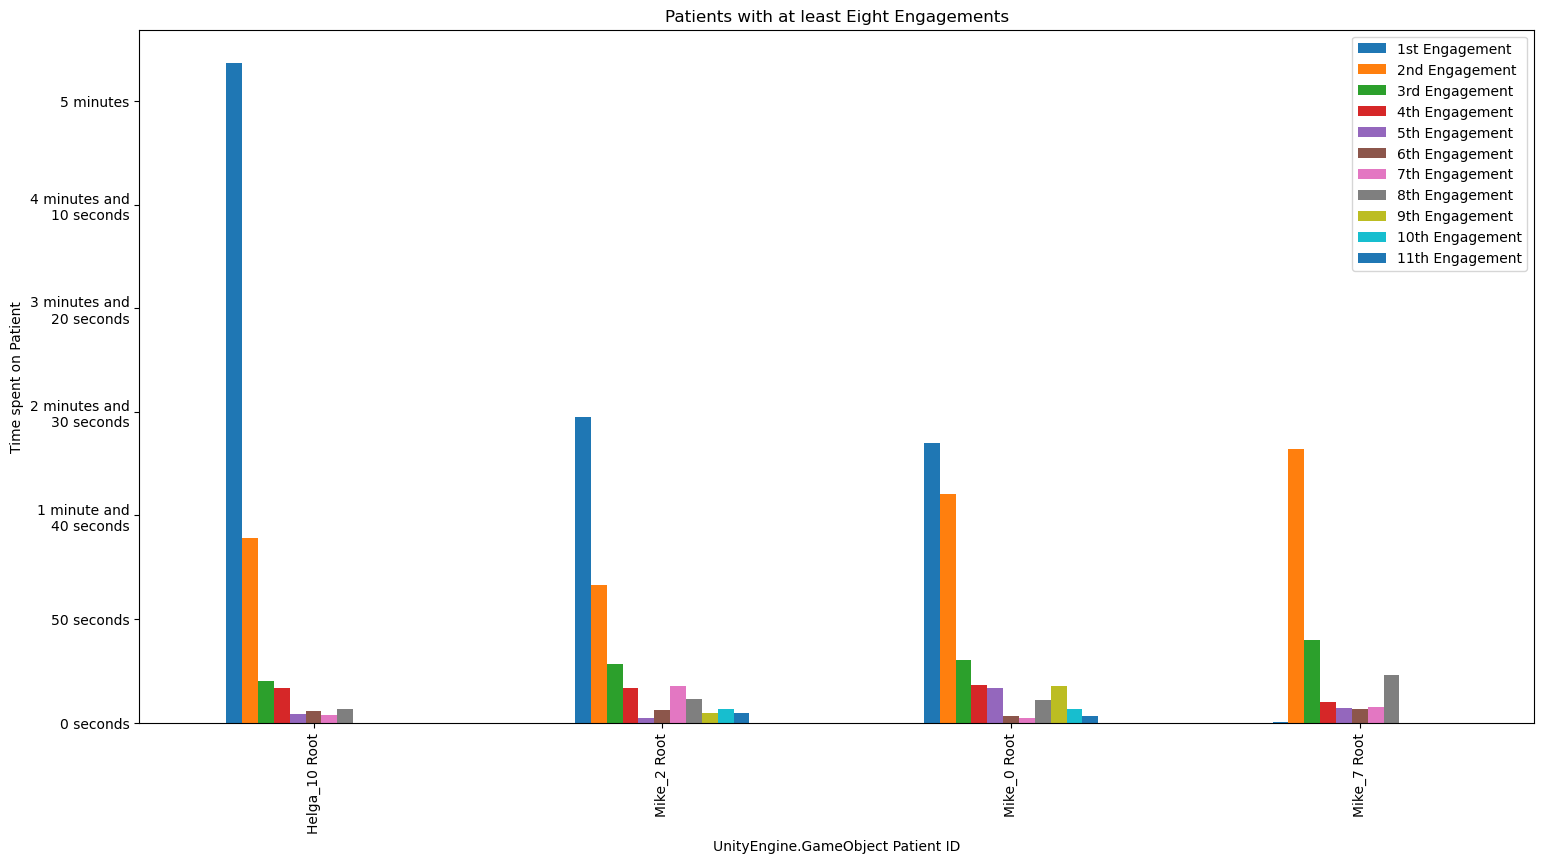

In [49]:

ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
df.plot(kind='bar', ax=ax)
ax.set_yticklabels([
    Text(0, 0.0, humanize.precisedelta(timedelta(milliseconds=0.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 50_000.0, humanize.precisedelta(timedelta(milliseconds=50_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 100_000.0, humanize.precisedelta(timedelta(milliseconds=100_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 150_000.0, humanize.precisedelta(timedelta(milliseconds=150_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 200_000.0, humanize.precisedelta(timedelta(milliseconds=200_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 250_000.0, humanize.precisedelta(timedelta(milliseconds=250_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 300_000.0, humanize.precisedelta(timedelta(milliseconds=300_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 350_000.0, humanize.precisedelta(timedelta(milliseconds=350_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(0, 400_000.0, humanize.precisedelta(timedelta(milliseconds=400_000.0)).replace(', ', ',\n').replace(' and ', ' and\n'))
]);
legend = plt.legend()
# print(dir(legend))

# Get the legend text objects.
legend_texts = legend.get_texts()
# for text_obj in legend_texts:
#     print(text_obj)
for i in range(11):
    legend_texts[i].set_text(f'{humanize.ordinal(i+1)} Engagement')
ax.set_title('Patients with at least Eight Engagements')
ax.set_xlabel('UnityEngine.GameObject Patient ID')
ax.set_ylabel('Time spent on Patient');

In [9]:

for patient_id, df in engagement_delta_df.groupby('patient_id'):
    for i in range(11):
        cn = f'delta{i:02d}'

'INJURY_RECORD, PATIENT_RECORD, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVE_IF_CAN, and S_A_L_T_WAVED'